# Import packages

In [1]:
import sys
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta

# FFT function
Get a mixed harmonics by n_harm harmonics to fit the date_0 to date_1 stock and predict date_1 to date_2,
df = dataframe

In [2]:
def FFT(n_harm,stock,date_0,date_1,date_2):
    data = yf.Ticker(stock).history(start=date_0, end=date_1)
    price = data['Close']
    x = np.array(price)
    data2 = yf.Ticker(stock).history(start=date_0, end=date_2)
    price2 = data2['Close']
    n_x = x.size
    t = np.arange(0, n_x)
    p = np.polyfit(t, x, 1)     # find linear trend in x
    x_notrend = x - p[0] * t    # detrended x
    x_freqdom = fft.fft(x_notrend,n = n_x)        
    f = fft.fftfreq(n_x)
    indexes = list(range(n_x))      # frequencies
    # sort method 1
    # indexes.sort(key = lambda i: np.absolute(f[i]))     # sort indexes by frequency, lower -> higher
    # sort method 2
    indexes.sort(key=lambda i: np.absolute(x_freqdom[i]))       # sort indexes by amplitudes, lower -> higher 
    indexes.reverse()       # sort indexes by amplitudes, higher -> lower 
    t = np.arange(0, price2.size)
    restored_sig = np.zeros(t.size)
    count = 0
    for i in indexes[1:1 + n_harm * 2]:
        if (count <= 100 or count >= (n_harm * 2 -2)): 
            if(count % 2 == 0):
                ampli = np.absolute(x_freqdom[i]) / n_x     # amplitude
                phase = np.angle(x_freqdom[i])      # phase
                signal = ampli * np.cos(2 * np.pi * f[i] * t + phase)
                restored_sig += signal
            count += 1
    signal = restored_sig
    df = pd.DataFrame()
    df.index = price2.index
    df['Close'] = signal
    # df = df.drop(df[df.index < date_1].index)
    return df

In [3]:
FFT(20,"^GSPC",'2021-01-01','2022-01-01','2022-02-01')

,Close
Date,
2020-12-31,-11.970234
2021-01-04,-22.558974
2021-01-05,-25.365900
2021-01-06,-20.196149
2021-01-07,-11.022842
...,...
2022-01-25,-1.577213
2022-01-26,-18.783085
2022-01-27,-35.140409


# peak_valleys frnction

In [4]:
def peak_valleys(pv_range,data):
    pd.options.mode.chained_assignment = None
    pv = data['Close']
    data['peaks'] = pd.Series(dtype='float64') 
    data['valleys'] = pd.Series(dtype='float64') 
    peaks = data['peaks']
    valleys = data['valleys']
    for idx in range(0, len(pv)):
        if pv[idx] == pv.iloc[idx-pv_range:idx+pv_range].max():
            peaks.iloc[idx] = pv[idx]
        if pv[idx] == pv.iloc[idx-pv_range:idx+pv_range].min():
            valleys.iloc[idx] = pv[idx]
    return peaks,valleys

In [5]:
# data = yf.Ticker("^GSPC").history(start='2021-01-01', end='2022-01-01')
# pv_range = 2
# peak_valleys(pv_range,data)

In [6]:
def peak_valleys_delay(pv_1,pv_2):
    import datetime
    df_p_1 = pd.DataFrame()
    df_p_1['peaks_1'] = pv_1['peaks']
    df_p_1 = df_p_1.dropna(how='all') 
    li_peak_1 = list(df_p_1['peaks_1'].index)
    df_p_2 = pd.DataFrame()
    df_p_2['peaks_2'] = pv_2['peaks']
    df_p_2 = df_p_2.dropna(how='all') 
    li_peak_2 = list(df_p_2['peaks_2'].index)
    li_peak = []
    for i in range(0,len(li_peak_2)): 
        temp = []
        temp_abs = []
        temp2 = []
        for j in range(0,len(li_peak_1)): 
            temp.append((li_peak_1[j] - li_peak_2[i]).days)
            temp_abs.append(abs(li_peak_1[j] - li_peak_2[i]).days)
        for k in range(0,len(temp_abs)):
            if temp_abs[k] == min(temp_abs) : 
                temp2 = round(temp[k])
        li_peak.append(temp2)
    df_p_2['delay'] = li_peak
    df_v_1 = pd.DataFrame()
    df_v_1['valleys_1'] = pv_1['valleys']
    df_v_1 = df_v_1.dropna(how='all') 
    li_valley_1 = list(df_v_1['valleys_1'].index)
    df_v_2 = pd.DataFrame()
    df_v_2['valleys_2'] = pv_2['valleys']
    df_v_2 = df_v_2.dropna(how='all') 
    li_valley_2 = list(df_v_2['valleys_2'].index)
    li_valley = []
    for i in range(0,len(li_valley_2)): 
        temp = []
        temp_abs = []
        temp2 = []
        for j in range(0,len(li_valley_1)): 
            temp.append((li_valley_1[j] - li_valley_2[i]).days)
            temp_abs.append(abs(li_valley_1[j] - li_valley_2[i]).days)
        for k in range(0,len(temp_abs)):
            if temp_abs[k] == min(temp_abs) : 
                temp2 = round(temp[k])
        li_valley.append(temp2)
    df_v_2['delay'] = li_valley
    return df_p_2['delay'],df_v_2['delay']

In [7]:
# data = yf.Ticker("^GSPC").history(start='2021-01-01', end='2022-01-01')
# data2 = FFT(20,"^GSPC",'2021-01-01','2021-06-01','2022-01-01')
# pv_range = 2
# data2['peaks'] = peak_valleys(pv_range,data2)[0]
# data2['valleys'] = peak_valleys(pv_range,data2)[1]
# data['peaks'] = peak_valleys(pv_range,data)[0]
# data['valleys'] = peak_valleys(pv_range,data)[1]
# data2['peaks_delay'] = peak_valleys_delay(data,data2)[0]
# data2['valleys_delay'] = peak_valleys_delay(data,data2)[1]
# data2

In [8]:
def draw_plot_1(data,df):
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    axes[0].plot(data.index, data['Close'], c='gray',label='data',linewidth=3)
    axes[1].plot(df.index, df['Close'],c='gray' ,label='Predict',linewidth=3)
    try :
        axes[0].plot(data.index,data['peaks'],'^',c='royalblue',label='peaks')
        axes[0].plot(data.index,data['valleys'],'v',c='orangered',label='valleys')
        axes[1].plot(df.index , df['peaks'],'^',c='royalblue',label='peaks')
        axes[1].plot(df.index , df['valleys'],'v',c='orangered',label='valleys')
    except:
        pass
    try:
        for i, label in enumerate(df['peaks_delay']):
            axes[1].annotate(label, (df['peaks'].index[i],  df['peaks'][i]),fontsize=14)
        for i, label in enumerate(df['valleys_delay']):
            axes[1].annotate(label, (df['valleys'].index[i],  df['valleys'][i]),fontsize=14)
    except:
        pass
    axes[0].set_ylabel("price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("amplitude", fontsize=14)
    axes[0].legend()
    axes[1].legend()
    plt.show()
    return 

# Score function
三種type計算fit_score，得score_p,score_v。 
fit_score為score_p及score_v取平均。
best_fit為取最接近零的score之harmonic。
slide_score為預測之第一個轉折delay。
final_score為slide_score取絕對值後取平均。

In [9]:
def fit_score(df,type):
    if type == 'mean':
        df_temp = df.drop(df[df['peaks_delay'].isna()].index)
        score_p = df_temp['peaks_delay'].mean()
        df_temp = df.drop(df[df['valleys_delay'].isna()].index)
        score_v = df_temp['valleys_delay'].mean()
    elif type == 'abs':
        df_temp = df.drop(df[df['peaks_delay'].isna()].index)
        score_p = abs(df['peaks_delay']).mean()
        df_temp = df.drop(df[df['valleys_delay'].isna()].index)
        score_v = abs(df['valleys_delay']).mean()
    else :
        return 'wrong type'
    return score_p,score_v

In [10]:
# data = yf.Ticker("^GSPC").history(start='2020-01-01', end='2021-02-01')
# data2 = FFT(19,"^GSPC",'2020-01-01','2021-01-01','2021-02-01')
# pv_range = 2
# data2['peaks'] = peak_valleys(pv_range,data2)[0]
# data2['valleys'] = peak_valleys(pv_range,data2)[1]
# data['peaks'] = peak_valleys(pv_range,data)[0]
# data['valleys'] = peak_valleys(pv_range,data)[1]
# data2['peaks_delay'] = peak_valleys_delay(data[data.index <= '2021-01-01'],data2[data2.index <= '2021-01-01'])[0]
# data2['valleys_delay'] = peak_valleys_delay(data[data.index <= '2021-01-01'],data2[data2.index <= '2021-01-01'])[1]
# print('abs =' ,fit_score(data2,'abs'))
# print('positive =',fit_score(data2,'positive'))
# print('mean =',fit_score(data2,'mean'))

In [11]:
# data2['peaks_delay'] = peak_valleys_delay(data,data2)[0]
# data2['valleys_delay'] = peak_valleys_delay(data,data2)[1]
# draw_plot_1(data,data2)

In [12]:
def get_first_delay(df):
    df2 = pd.DataFrame()
    df2['peaks_delay'] = df['peaks_delay']
    df2['valleys_delay'] = df['valleys_delay']
    df2 = df2.dropna(how='all')
    if np.isnan(df2['peaks_delay'].iloc[0]) == False :
        Date = df2['peaks_delay'].index[0]
        delay = df2['peaks_delay'].iloc[0]
        pv = 'peaks'
    else :
        Date = df2['valleys_delay'].index[0]
        delay = df2['valleys_delay'].iloc[0]
        pv = 'valleys'
    # Date = datetime.datetime.strftime(Date,'%Y-%m-%d')
    return Date,delay,pv

In [13]:
# data = yf.Ticker("^GSPC").history(start='2020-01-01', end='2021-01-01')
# data2 = FFT(20,"^GSPC",'2020-01-01','2021-01-01','2021-02-01')
# pv_range = 2
# data2['peaks'] = peak_valleys(pv_range,data2)[0]
# data2['valleys'] = peak_valleys(pv_range,data2)[1]
# data['peaks'] = peak_valleys(pv_range,data)[0]
# data['valleys'] = peak_valleys(pv_range,data)[1]
# data2['peaks_delay'] = peak_valleys_delay(data[data.index <= '2021-01-01'],data2[data2.index <= '2021-01-01'])[0]
# data2['valleys_delay'] = peak_valleys_delay(data[data.index <= '2021-01-01'],data2[data2.index <= '2021-01-01'])[1]
# get_first_delay(data2)

In [14]:
def main_function_1(stock,date_0,date_1,date_2,n_harm,pv_range,type):
    data = yf.Ticker(stock).history(start=date_0, end=date_2)
    data['peaks'] = peak_valleys(pv_range,data)[0]
    data['valleys'] = peak_valleys(pv_range,data)[1]
    df = FFT(n_harm,stock,date_0,date_1,date_2)
    df['peaks'] = peak_valleys(pv_range,df)[0]
    df['valleys'] = peak_valleys(pv_range,df)[1]
    df['peaks_delay'] = peak_valleys_delay(data[data.index <= date_1],df[df.index <= date_1])[0]
    df['valleys_delay'] = peak_valleys_delay(data[data.index <= date_1],df[df.index <= date_1])[1]
    score = fit_score(df,type) 
    score = (score[0] + score[1])/2
    df['peaks_delay'] = peak_valleys_delay(data,df)[0]
    df['valleys_delay'] = peak_valleys_delay(data,df)[1]
    return data,df,score

In [15]:
# a = main_function_1("^GSPC",'2021-01-01','2022-01-01','2022-02-01',20,2,'abs')
# data = a[0]
# df = a[1]
# score = a[2]
# draw_plot_1(data,df)
# print(score)

In [16]:
def main_function_slide(stock,date_start,data_range,predict_range,n_harm,pv_range,n_slide):
    date_start = datetime.datetime.strptime(date_start, '%Y-%m-%d')
    date_0 = date_start + relativedelta(months=-data_range)
    df = pd.DataFrame()
    data = pd.DataFrame()
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    for i in range(n_slide) :
        date_1 = date_0 + relativedelta(months=+data_range)
        date_2 = date_1 + relativedelta(months=+predict_range)
        temp = FFT(n_harm,stock,date_0,date_1,date_2)
        temp = temp.drop(temp[temp.index < date_1].index)
        axes[1].plot(temp.index, temp['Close'], label='Predict',linewidth=3)
        temp['peaks'] = peak_valleys(pv_range,temp)[0]
        temp['valleys'] = peak_valleys(pv_range,temp)[1]
        data_temp = yf.Ticker(stock).history(start=date_1, end=date_2)
        axes[0].plot(data_temp.index, data_temp['Close'], linewidth=3, label='Test_data')
        data_temp['peaks'] = peak_valleys(pv_range,data_temp)[0]
        data_temp['valleys'] = peak_valleys(pv_range,data_temp)[1]
        temp['peaks_delay'] = peak_valleys_delay(data_temp,temp)[0]
        temp['valleys_delay'] = peak_valleys_delay(data_temp,temp)[1]
        axes[0].plot(data_temp.index,data_temp['peaks'],'^',c='royalblue',label='peaks')
        axes[0].plot(data_temp.index,data_temp['valleys'],'v',c='orangered',label='valleys')
        axes[1].plot(temp.index , temp['peaks'],'^',c='royalblue',label='peaks')
        axes[1].plot(temp.index , temp['valleys'],'v',c='orangered',label='valleys')
        df = pd.concat([df,temp])
        data = pd.concat([data,data_temp])
        date_0 = date_0 + relativedelta(months=+1)
    for i, label in enumerate(df['peaks_delay']):
            axes[1].annotate(label, (df['peaks'].index[i],  df['peaks'][i]),fontsize=14)
    for i, label in enumerate(df['valleys_delay']):
        axes[1].annotate(label, (df['valleys'].index[i],  df['valleys'][i]),fontsize=14)
    axes[0].set_ylabel("price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("amplitude", fontsize=14)
    plt.show()
    return data,df

In [17]:
# a = main_function_slide("^GSPC",'2021-01-01',12,1,20,2,12)
# data = a[0]
# df = a[1]
# print('abs =' ,fit_score(df,'abs'))
# print('positive =',fit_score(df,'positive'))
# print('mean =',fit_score(df,'mean'))

In [18]:
def main_function_1_fit_score(stock,date_0,date_1,date_2,n_harm_0,n_harm_1,pv_range,type):
    score = pd.Series(dtype='float64')
    df = pd.Series(dtype='float64')
    for i in range(n_harm_0,n_harm_1+1):
        temp = main_function_1(stock,date_0,date_1,date_2,i,pv_range,type)
        score = pd.concat([score,pd.Series(temp[2])])
    # print(df)
    score = score.reset_index(drop = True)
    score = score.abs()
    best_fit = score.idxmin() + n_harm_0
    temp_2 = main_function_1(stock,date_0,date_1,date_2,best_fit,pv_range,type)
    data,df,score = temp_2
    return data,df,score,best_fit

In [19]:
# a = main_function_1_fit_score("^GSPC",'2021-06-01','2022-07-01','2022-02-01',15,17,2,'mean')
# a

In [20]:
def main_function_slide_fit_score(stock,date_start,data_range,predict_range,n_harm_0,n_harm_1,pv_range,n_slide,type):
    date_start = datetime.datetime.strptime(date_start, '%Y-%m-%d')
    date_0 = date_start + relativedelta(months=-data_range)
    df = pd.DataFrame()
    data = pd.DataFrame()
    fit_score = []
    best_fit = []
    slide_score = []
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    for i in range(n_slide) :
        date_1 = date_0 + relativedelta(months=+data_range)
        date_2 = date_1 + relativedelta(months=+predict_range)
        data_drop,temp,score_temp,best_fit_temp = main_function_1_fit_score(stock,date_0,date_1,date_2,n_harm_0,n_harm_1,2,type)
        fit_score.append(round(score_temp,2))
        best_fit.append(best_fit_temp)
        temp = temp.drop(temp[temp.index < date_1].index)
        axes[1].plot(temp.index, temp['Close'], label='Predict',linewidth=3)
        temp['peaks'] = peak_valleys(pv_range,temp)[0]
        temp['valleys'] = peak_valleys(pv_range,temp)[1]
        data_temp = yf.Ticker(stock).history(start=date_1, end=date_2)
        axes[0].plot(data_temp.index, data_temp['Close'], linewidth=3, label='Test_data')
        data_temp['peaks'] = peak_valleys(pv_range,data_temp)[0]
        data_temp['valleys'] = peak_valleys(pv_range,data_temp)[1]
        temp['peaks_delay'] = peak_valleys_delay(data_temp,temp)[0]
        temp['valleys_delay'] = peak_valleys_delay(data_temp,temp)[1]
        df_temp_score = pd.concat([temp['peaks_delay'],temp['valleys_delay']])
        try:
            slide_score.append(df_temp_score.dropna()[0])
        except:
            pass
        axes[0].plot(data_temp.index,data_temp['peaks'],'^',c='royalblue',label='peaks')
        axes[0].plot(data_temp.index,data_temp['valleys'],'v',c='orangered',label='valleys')
        axes[1].plot(temp.index , temp['peaks'],'^',c='royalblue',label='peaks')
        axes[1].plot(temp.index , temp['valleys'],'v',c='orangered',label='valleys')
        df = pd.concat([df,temp])
        data = pd.concat([data,data_temp])
        date_0 = date_0 + relativedelta(months=+predict_range)
    for i, label in enumerate(df['peaks_delay']):
            axes[1].annotate(label, (df['peaks'].index[i],  df['peaks'][i]),fontsize=14)
    for i, label in enumerate(df['valleys_delay']):
        axes[1].annotate(label, (df['valleys'].index[i],  df['valleys'][i]),fontsize=14)
    axes[0].set_ylabel("price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("amplitude", fontsize=14)
    final_score =  round(sum([abs(ele) for ele in slide_score]) / len(slide_score) ,2)
    plt.show()
    return data,df,fit_score,best_fit,final_score

In [21]:
# slide_mean = main_function_slide_fit_score("^GSPC",'2021-01-01',12,1,10,11,2,1,'mean')
# print(slide_mean[2])
# print(slide_mean[3])
# print(slide_mean[4])

In [22]:
def main_function_slide_fit_score_slide_range(stock,date_start,data_range,slide_range,n_slide,pv_range,n_harm_0,n_harm_1,type):
    predict_range = data_range
    date_start = datetime.datetime.strptime(date_start, '%Y-%m-%d')
    date_0 = date_start + relativedelta(months=-data_range)
    df = pd.DataFrame()
    data = pd.DataFrame()
    fit_score = []
    best_fit = []
    df_delay = pd.DataFrame(columns=['Date','delay','pv'])
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    for i in range(n_slide) :
        date_1 = date_0 + relativedelta(months=+data_range)
        date_2 = date_1 + relativedelta(months=+predict_range)
        data_drop,temp,score_temp,best_fit_temp = main_function_1_fit_score(stock,date_0,date_1,date_2,n_harm_0,n_harm_1,pv_range,type)
        fit_score.append(round(score_temp,2))
        best_fit.append(best_fit_temp)
        temp = temp.drop(temp[temp.index < date_1].index)
        # axes[1].plot(temp.index, temp['Close'], label='Predict',linewidth=3)
        temp['peaks'] = peak_valleys(pv_range,temp)[0]
        temp['valleys'] = peak_valleys(pv_range,temp)[1]
        data_temp = yf.Ticker(stock).history(start=date_1, end=date_2)
        data_temp['peaks'] = peak_valleys(pv_range,data_temp)[0]
        data_temp['valleys'] = peak_valleys(pv_range,data_temp)[1]
        temp['peaks_delay'] = peak_valleys_delay(data_temp,temp)[0]
        temp['valleys_delay'] = peak_valleys_delay(data_temp,temp)[1]
        # axes[1].plot(temp.index , temp['peaks'],'^',c='royalblue',label='peaks')
        # axes[1].plot(temp.index , temp['valleys'],'v',c='orangered',label='valleys')
        temp = temp.drop(columns='Close')
        # print(temp.dropna(how='all'))
        df_delay.loc[i,'Date'],df_delay.loc[i,'delay'],df_delay.loc[i,'pv'] = get_first_delay(temp)
        df = pd.concat([df[df.index < temp.index[0]],temp])
        date_0 = date_0 + relativedelta(weeks=+slide_range)
    data = yf.Ticker(stock).history(start=date_start, end=date_2)
    axes[0].plot(data.index, data['Close'], 'gray', linewidth=3, label='Test_data')
    data['peaks'] = peak_valleys(pv_range,data)[0]
    data['valleys'] = peak_valleys(pv_range,data)[1]
    axes[0].plot(data.index,data['peaks'],'^',c='royalblue',label='peaks')
    axes[0].plot(data.index,data['valleys'],'v',c='orangered',label='valleys')
    # for i, label in enumerate(df['peaks_delay']):
    #     axes[1].annotate(label, (df['peaks'].index[i],  df['peaks'][i]),fontsize=14)
    # for i, label in enumerate(df['valleys_delay']):
    #     axes[1].annotate(label, (df['valleys'].index[i],  df['valleys'][i]),fontsize=14)
    df_delay = df_delay.set_index(df_delay['Date'])
    df_delay = df_delay.drop(columns='Date')
    axes[0].set_ylabel("price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("delay", fontsize=14)

    final_score =  round(sum([abs(ele) for ele in df_delay['delay']]) / len(df_delay['delay']) ,2)
    a = pd.DataFrame(index=df.index,columns=['delay','pv'])
    a.loc[df_delay.index] = df_delay
    axes[0].set_xlim(data.index[0],data.index[-1])
    axes[1].set_xlim(data.index[0],data.index[-1])
    for i, label in enumerate(a['delay']):
        if a['pv'][i] == 'peaks' :
            axes[1].plot(a['delay'].index[i] , a['delay'][i],'*',c='royalblue',label='peaks')
        else :
            axes[1].plot(a['delay'].index[i] , a['delay'][i],'*',c='orangered',label='valleys')
        axes[1].annotate(label, (a['delay'].index[i],  a['delay'][i]),fontsize=14)
    # axes[1].plot(a.index,a['delay'],'*',c='royalblue',label='peaks')
    # axes[0].plot(data.index,data['valleys'],'v',c='orangered',label='valleys')
    plt.show()
    return data,df,fit_score,best_fit,final_score,df_delay

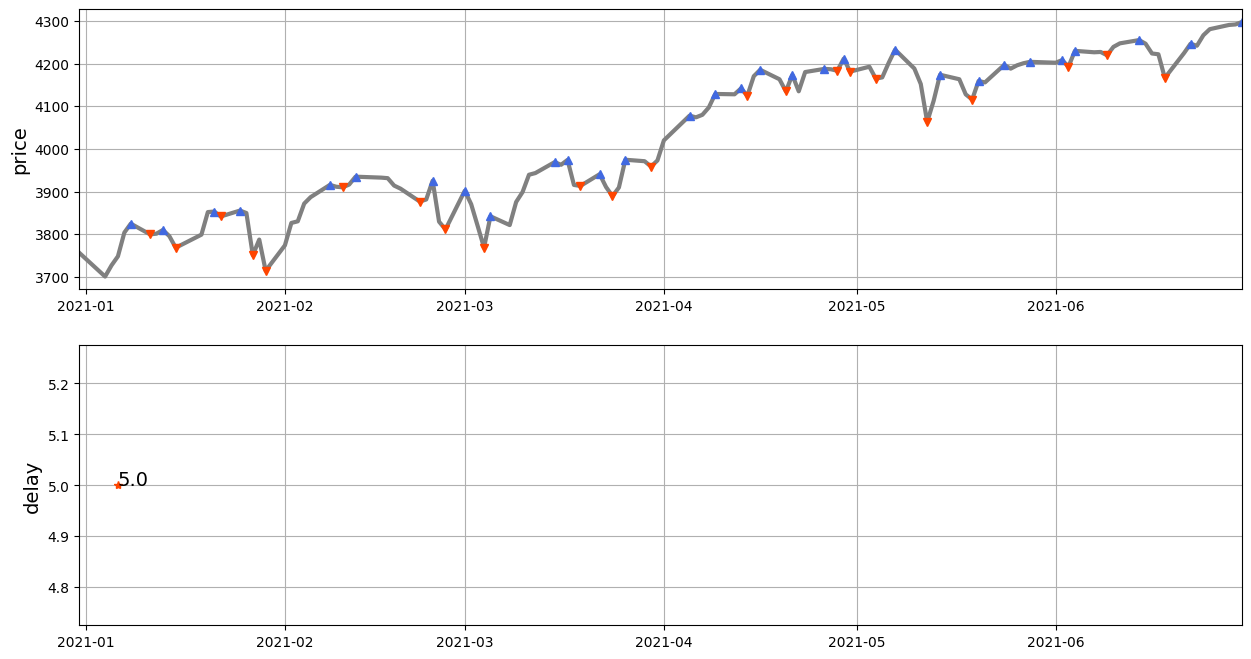

[1.9]
[20]
5.0
           delay       pv
Date                     
2021-01-06   5.0  valleys


In [25]:
slide_abs_test = main_function_slide_fit_score_slide_range(
    stock="^GSPC",date_start='2021-01-01',data_range=6,
    slide_range=2,n_slide=1,pv_range=2,n_harm_0=20,n_harm_1=20,type='abs'
    )
print(slide_abs_test[2])
print(slide_abs_test[3])
print(slide_abs_test[4])
print(slide_abs_test[5])

In [24]:
# slide_mean_test = main_function_slide_fit_score_slide_range(
#     stock="^GSPC",date_start='2021-01-01',data_range=6,
#     slide_range=2,n_slide=24,pv_range=2,n_harm_0=20,n_harm_1=40,type='mean'
#     )
# print(slide_mean_test[2])
# print(slide_mean_test[3])
# print(slide_mean_test[4])
# print(slide_mean_test[5])